<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/07.02-MIMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to use functions from `tbcontrol`, `numpy` and `matplotlib` to solve Multiple-Input Multiple-Output control problems.

In [3]:
!pip install tbcontrol
from tbcontrol import blocksim, fopdtitae
import numpy # as we usual need some numerical gadgets
import matplotlib.pyplot as plt # in order to produce nice plots
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## [Example 10.6](https://ia802909.us.archive.org/32/items/process-control-a-first-course-with-matlab/Process%20Control%20A%20First%20Course%20with%20MATLAB.pdf#page=236) (Pao C. Chau, Process Control: A First Course with MATLAB)

In this model, $x_D$ and $x_B$ are the distillate and the bottom compositions, respectively; $L$ is the reflux flow rate, and $V$ is the boil-up rate.

![](https://www.researchgate.net/profile/Horst-Schulte/publication/268386449/figure/fig9/AS:563405431611393@1511337730120/Distillation-column-LV-configuration-87.png)

In [99]:
# Example 10.6 transfer function parameters
gains = numpy.array([[0.07,-0.05],
                    [0.1,-0.15]])
taus = numpy.array([[12.0,15.0],
                   [11.0,10.0]])
delays = numpy.array([[3.0,1.0],
                     [4.0,2.0]])

# Generic 2x2 open loop diagram
def ol_diag(gains=gains, taus=taus, delays=delays, u_0=1, u_1=0):
  N = gains.ndim # system size
  G = {} # collector
  for inp in range(N):
    for outp in range(N):
        G[(outp, inp)] = blocksim.LTI(f"G_{outp}_{inp}", f"u_{inp}", f"yp_{inp}_{outp}", 
                                      gains[outp][inp], [taus[outp][inp], 1], delays[outp][inp])
  sums = {f'y_{outp}': [f"+yp_{inp}_{outp}" for inp in range(N)] for outp in range(N)}
  inputs = {'u_0' : blocksim.step(starttime=20, size=u_0), 
            'u_1' : blocksim.step(starttime=20, size=u_1)}
  return blocksim.Diagram(list(G.values()), sums, inputs)

# Generic 2x2 diagram simulating and ploting
def diag_sim_plot(diagram=diagram, ts=ts, inplab=['u_0', 'u_1'], outlab=['y_0', 'y_1']):
  result = diagram.simulate(ts)
  aux = [['y_0', 'y_1'], 
         ['u_0', 'u_1']]
  aux1 = [outlab, 
          inplab]
  aux3 = [['blue', 'orange'],
          ['green', 'red']]
  fig, axs = plt.subplots(2, 2, figsize=(15,10))
  for j in range(2):
    for k in range(2):
      axs[j, k].plot(ts, result[aux[j][k]], f'tab:{aux3[j][k]}')
      axs[j, k].set(xlabel='Time', ylabel=aux1[j][k])
      if 'ysp_0' in list(result.keys()):
        axs[0, k].plot(ts, result[f'ysp_{k}'], f'tab:{aux3[0][k]}')

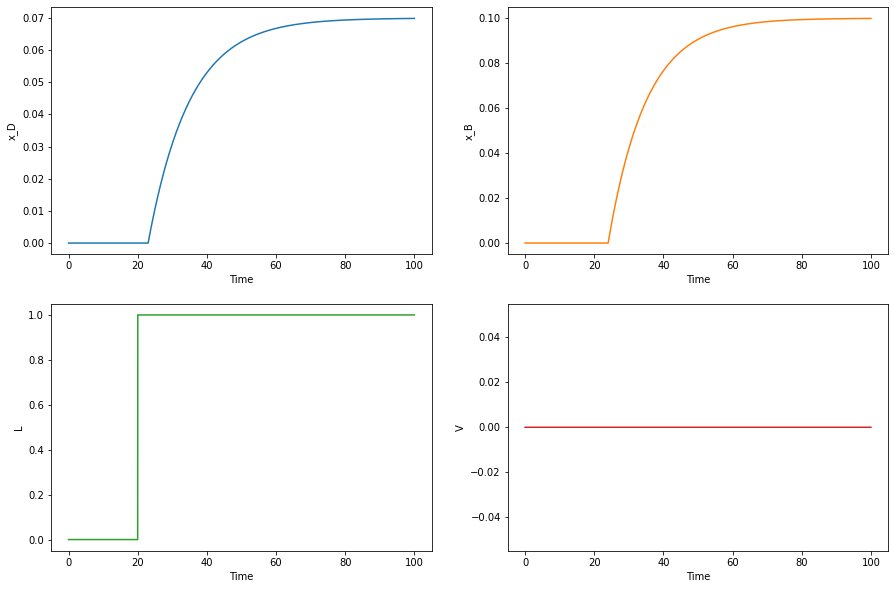

In [71]:
# Simulation time
ts  = numpy.linspace(start=0, stop=100, num=100*100)
# Simulating and ploting an unit-step in L
diag_sim_plot(diagram=ol_diag(), inplab=['L', 'V'], outlab=['x_D', 'x_B'])

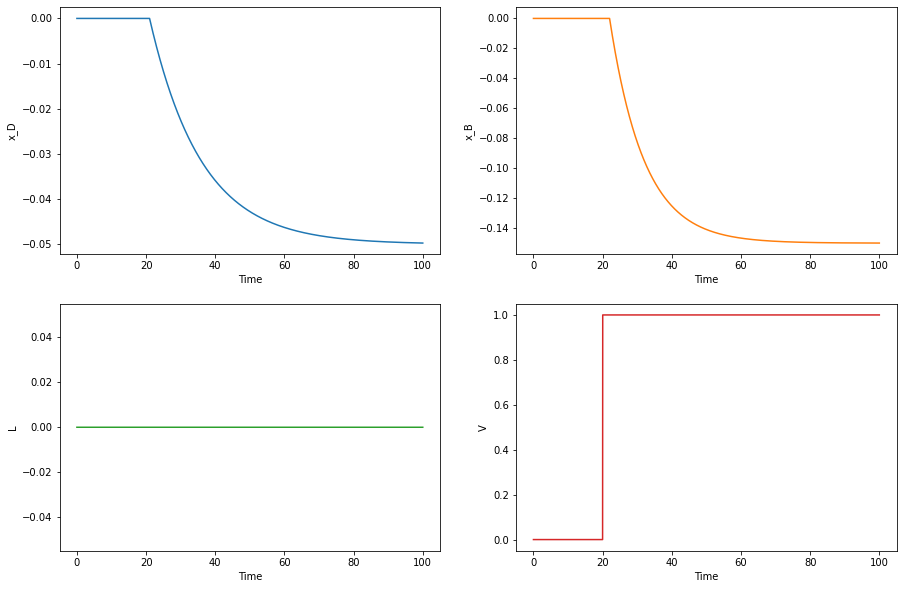

In [70]:
# Simulating and ploting an unit-step in V
diag_sim_plot(diagram=ol_diag(u_0=0, u_1=1), inplab=['L', 'V'], outlab=['x_D', 'x_B'])

In [73]:
# Relative gain array (see footnote 11 p. 216)
H = numpy.transpose(numpy.linalg.inv(K))
LAMBDA = numpy.multiply(K, H)
LAMBDA

array([[ 1.90909091, -0.90909091],
       [-0.90909091,  1.90909091]])

In [81]:
# Tuning the XD-L loop using ITAE tuning rule for servo control
Kcs = numpy.zeros(2)
tauIs = numpy.zeros(2)
for k in range(2):
  Kcs[k], tauIs[k] = fopdtitae.parameters(gains[k][k], taus[k][k], delays[k][k], type_of_input='Set point', type_of_controller='PI')

In [82]:
# Generic 2x2 closed loop with PI controllers diagram
def cl_PI_diag(Kcs=Kcs, tauIs=tauIs, gains=gains, taus=taus, delays=delays, ysp_0=1, ysp_1=0):
  N = gains.ndim # system size
  G = {} # collector
  for inp in range(N):
    for outp in range(N):
        G[(outp, inp)] = blocksim.LTI(f"G_{outp}_{inp}", f"u_{inp}", f"yp_{inp}_{outp}", 
                                      gains[outp][inp], [taus[outp][inp], 1], delays[outp][inp])
  sums = {f'y_{outp}': [f"+yp_{inp}_{outp}" for inp in range(N)] for outp in range(N)}
  controllers = {'Gc_0': blocksim.PI('Gc_0', 'e_0', 'u_0', Kcs[0], tauIs[0]),
                 'Gc_1': blocksim.PI('Gc_1', 'e_1', 'u_1', Kcs[1], tauIs[1])}
  for i in range(N):
    sums[f'e_{i}'] = [f'+ysp_{i}', f'-y_{i}']
  inputs = {'ysp_0' : blocksim.step(starttime=20, size=ysp_0), 
            'ysp_1' : blocksim.step(starttime=20, size=ysp_1)}
  return blocksim.Diagram(list(G.values()) + list(controllers.values()), sums, inputs)

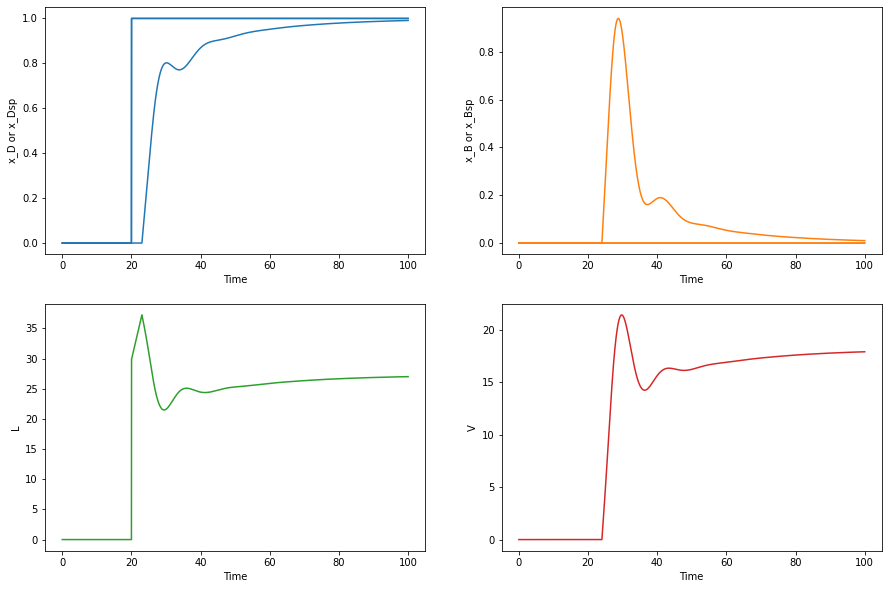

In [101]:
# Simulating and ploting an unit-step in x_D setpoint
diag_sim_plot(diagram=cl_PI_diag(), inplab=['L', 'V'], outlab=['x_D or x_Dsp', 'x_B or x_Bsp'])

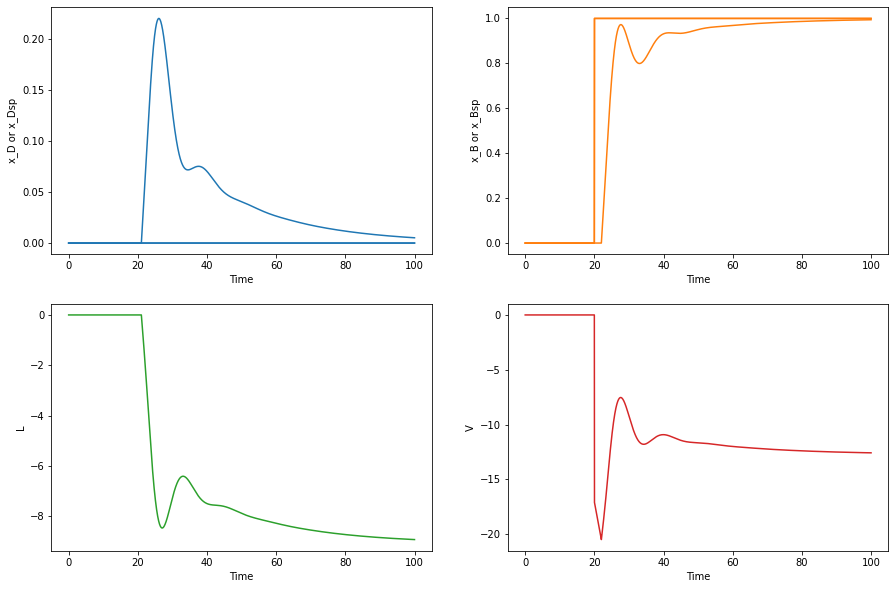

In [102]:
# Simulating and ploting an unit-step in x_B setpoint
diag_sim_plot(diagram=cl_PI_diag(ysp_0=0, ysp_1=1), inplab=['L', 'V'], outlab=['x_D or x_Dsp', 'x_B or x_Bsp'])

In [9]:
# Example 10.6 (closed loop with PI controllers and decouplers)
def example_106_PI_decoup(ts=ts, K=K, tau=tau, td=td, Kc=Kc, taui=taui, XD_sp=0.1, XB_sp=0.0):
  # Creating the blocks
  D21 = blocksim.LTI('D21', 'M1', 'M21', [-K[1][0]/K[1][1]*tau[1][1], -K[1][0]/K[1][1]], [tau[1][0], 1]) # -G21/G22
  D21d = blocksim.Deadtime('D21d', 'M21', 'M21d', td[1][0]-td[1][1])
  D12 = blocksim.LTI('D12', 'M2', 'M12', [-K[0][1]/K[0][0]*tau[0][0], -K[0][1]/K[0][0]], [tau[0][1], 1]) # -G12/G11
  D12d = blocksim.Deadtime('D12d', 'M12', 'M12d', td[0][1]-td[0][0])
  Gc1 = blocksim.PI('Gc1', 'E1', 'M1', Kc[0], taui[0])
  Gc2 = blocksim.PI('Gc2', 'E2', 'M2', Kc[1], taui[1])
  G11 = blocksim.LTI('G11', 'L', 'Y11', K[0][0], [tau[0][0], 1])
  td11 = blocksim.Deadtime('D11', 'Y11', 'Y11d', td[0][0])
  G12 = blocksim.LTI('G12', 'V', 'Y12', K[0][1], [tau[0][1], 1])
  td12 = blocksim.Deadtime('D12', 'Y12', 'Y12d', td[0][1])
  G21 = blocksim.LTI('G21', 'L', 'Y21', K[1][0], [tau[1][0], 1])
  td21 = blocksim.Deadtime('D21', 'Y21', 'Y21d', td[1][0])
  G22 = blocksim.LTI('G22', 'V', 'Y22', K[1][1], [tau[1][1], 1])
  td22 = blocksim.Deadtime('D22', 'Y22', 'Y22d', td[1][1])

  # Creating the diagram
  diagram = blocksim.Diagram([D21, D21d, D12, D12d, Gc1, Gc2, G11, td11, G12, td12, G21, td21, G22, td22], 
                               sums={'XD': ('+Y11d', '+Y12d'), 
                                     'XB': ('+Y21d', '+Y22d'),
                                     'E1': ('+XD_sp', '-XD'),
                                     'E2': ('+XB_sp', '-XB'),
                                     'L' : ('+M1', '+M12d'),
                                     'V' : ('+M2', '+M21d')}, 
                               inputs={'XD_sp': blocksim.step(starttime=20,size=XD_sp), 
                                       'XB_sp' : blocksim.step(starttime=20,size=XB_sp)})
  simulation_results = diagram.simulate(ts, progress=True)
  return simulation_results['L'], simulation_results['V'], simulation_results['XD'], simulation_results['XB'], simulation_results['XD_sp'], simulation_results['XB_sp']

In [10]:
# Simulating a step of 0.1 in XD_sp
L, V, XD, XB, XD_sp, XB_sp = example_106_PI_decoup()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Text(0, 0.5, '$V$'), Text(0.5, 0, 'Time')]

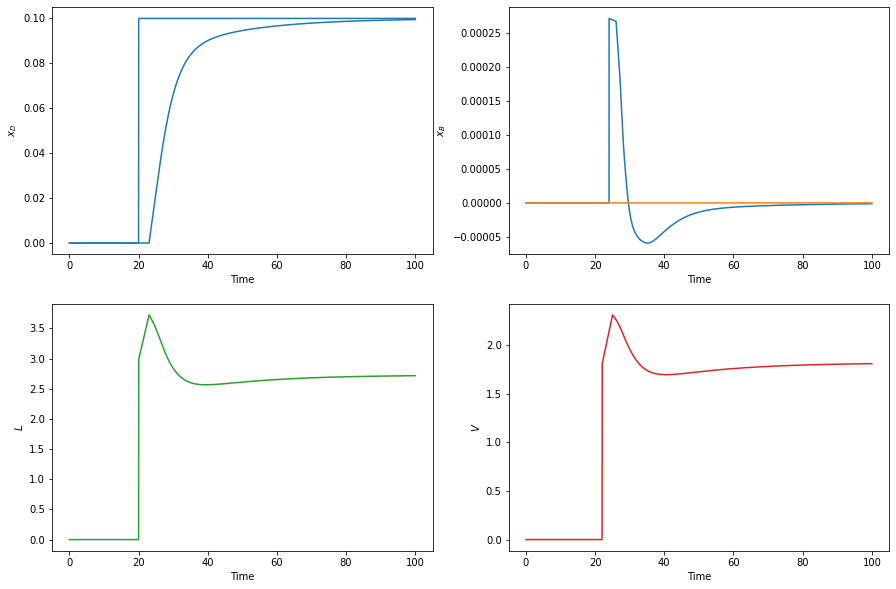

In [11]:
# Ploting a step of 0.1 in XD_sp
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0, 0].plot(ts, XD, ts, XD_sp, 'tab:blue')
axs[0, 0].set(xlabel='Time', ylabel='$x_D$')
axs[0, 1].plot(ts, XB, ts, XB_sp, 'tab:orange')
axs[0, 1].set(xlabel='Time', ylabel='$x_B$')
axs[1, 0].plot(ts, L, 'tab:green')
axs[1, 0].set(xlabel='Time', ylabel='$L$')
axs[1, 1].plot(ts, V, 'tab:red')
axs[1, 1].set(xlabel='Time', ylabel='$V$')